In [4]:
import numpy as np
import pandas as pd


import matplotlib
import matplotlib.pyplot as plt
from pylab import imshow

import os, os.path
import sys


sys.path.append('/Users/hn/Documents/00_GitHub/Ag/NASA/Python_codes/')
import NASA_core as nc
import NASA_plot_core as rcp

We need to take care of the unusually high values in December, January, and Feb. See why the code has not worked as aggressively as it should

# Define directories and parameters

In [136]:
color_dict = {'raw': 'k',
              'outlier': 'red',
              'jump':'green',
              'regular':'#8c564b', # '#8c564b' '#ff7f0e' #2ca02c
              'SG': '#d62728'}

# Marker shapes: https://matplotlib.org/stable/api/markers_api.html
style_dict = {'raw': 'solid',
              'outlier':'solid', 
              'jump':'dotted', 
              'regular':'dashdot',
              'SG': 'solid'
             }

In [7]:
landsat_dir = "/Users/hn/Documents/01_research_data/NASA/VI_TS/data_for_train_individual_counties/"
VI_idx="EVI"

In [8]:
landsat_fNames = [x for x in os.listdir(landsat_dir) if x.endswith(".csv")]

landsat_DF = pd.DataFrame()
for fName in landsat_fNames:
    curr = pd.read_csv(landsat_dir+fName)
    curr.dropna(subset=[VI_idx], inplace=True)
    landsat_DF=pd.concat([landsat_DF, curr])

In [9]:
landsat_DF.head(2)

,ID,NDVI,EVI,system_start_time
67,57969_WSDA_SF_2016,0.082224,0.090585,1.420137e+12
291,53072_WSDA_SF_2016,0.017135,0.037315,1.420137e+12


In [43]:
an_ID = "106509_WSDA_SF_2017"
a_raw_field = landsat_DF[landsat_DF.ID==an_ID].copy()

a_raw_field = nc.add_human_start_time_by_system_start_time(a_raw_field)

######## Pick only 1 year: the middle year out of 3 years we fetched
curr_year=a_raw_field.human_system_start_time.dt.year.unique()[1]
a_raw_field=a_raw_field[a_raw_field.human_system_start_time.dt.year==curr_year]


a_raw_field.dropna(subset=[VI_idx], inplace=True)

a_raw_field.sort_values(by=["ID", 'human_system_start_time'], inplace=True)
a_raw_field.reset_index(drop=True, inplace=True)

a_raw_field.head(2)

,ID,NDVI,EVI,system_start_time,human_system_start_time
0,106509_WSDA_SF_2017,-0.012809,-0.045475,1.483556e+12,2017-01-04
1,106509_WSDA_SF_2017,-0.019658,-0.202527,1.483642e+12,2017-01-05


(-1.05, 1.05)

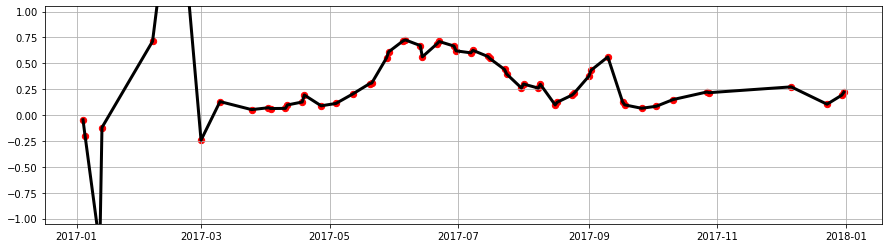

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4), sharex=False, sharey='col', # sharex=True, sharey=True,
                       gridspec_kw={'hspace': 0.35, 'wspace': .05});
ax.grid(True)

ax.plot(a_raw_field['human_system_start_time'], 
        a_raw_field[VI_idx], 
        linewidth=3, \
        label="raw",
        color=color_dict['raw'], 
        linestyle=style_dict["raw"]);

ax.scatter(a_raw_field['human_system_start_time'], 
           a_raw_field[VI_idx], 
           s=40, c="r", label="1. no outlier")

ax.set_ylim(-1.05, 1.05)

# 1. Remove Boundary Violaters

In [65]:
no_Outlier_TS = nc.interpolate_outliers_EVI_NDVI(outlier_input=a_raw_field, 
                                                 given_col=VI_idx)
no_Outlier_TS.loc[no_Outlier_TS[VI_idx]<0 , VI_idx] = 0 

(-1.05, 1.05)

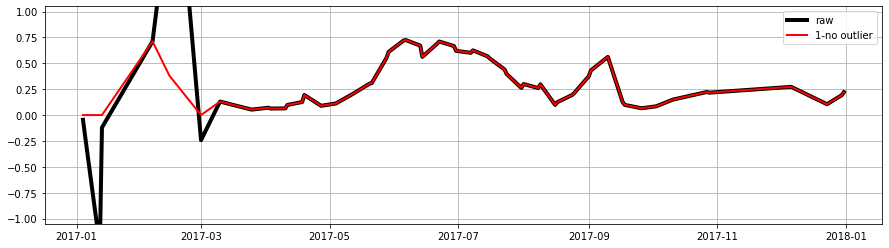

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4), sharex=False, sharey='col', # sharex=True, sharey=True,
                       gridspec_kw={'hspace': 0.35, 'wspace': .05});
ax.grid(True)


ax.plot(a_raw_field['human_system_start_time'], 
        a_raw_field[VI_idx], 
        linewidth=4, \
        label="raw",
        color=color_dict['raw'], 
        linestyle=style_dict["raw"]);

ax.plot(no_Outlier_TS['human_system_start_time'], 
        no_Outlier_TS[VI_idx], 
        linewidth=2, label="1-no outlier",\
        color=color_dict["outlier"], 
        linestyle=style_dict["outlier"]);

ax.legend(loc="upper right");
ax.set_ylim(-1.05, 1.05)

# 2. Correct Big Jumps

In [67]:
no_Outlier_no_jump=no_Outlier_TS.copy()
no_Outlier_no_jump = nc.correct_big_jumps_1DaySeries_JFD(dataTMS_jumpie = no_Outlier_no_jump, 
                                                         give_col = VI_idx, 
                                                         maxjump_perDay = 0.018)

(-0.1, 1.05)

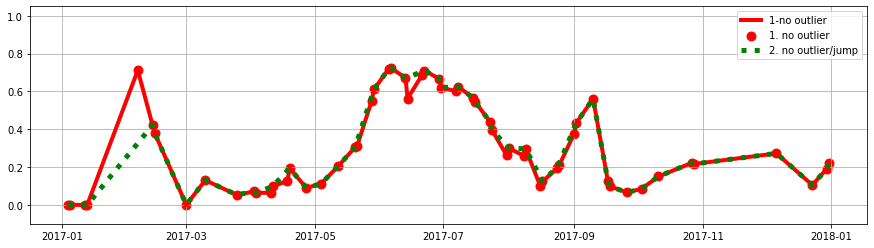

In [131]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4), sharex=False, sharey='col', # sharex=True, sharey=True,
                       gridspec_kw={'hspace': 0.35, 'wspace': .05});
ax.grid(True)


# ax.plot(a_raw_field['human_system_start_time'], 
#         a_raw_field[VI_idx], 
#         linewidth=4, \
#         label="raw",
#         color=color_dict['raw'], 
#         linestyle=style_dict["raw"]);

ax.plot(no_Outlier_TS['human_system_start_time'], 
        no_Outlier_TS[VI_idx], 
        linewidth=4, label="1-no outlier",\
        color=color_dict["outlier"], 
        linestyle=style_dict["outlier"]);

ax.scatter(no_Outlier_TS['human_system_start_time'], 
           no_Outlier_TS[VI_idx], 
           s=80, c="r", label="1. no outlier")

ax.plot(no_Outlier_no_jump['human_system_start_time'], 
        no_Outlier_no_jump[VI_idx], 
        linewidth=5, label="2. no outlier/jump",\
        color=color_dict["jump"], 
        linestyle=style_dict["jump"]);

ax.legend(loc="upper right");
ax.set_ylim(-.1, 1.05)

# Correct big jumps for second time

In [100]:
# no_Outlier_no_jump_2=no_Outlier_no_jump.copy()
# no_Outlier_no_jump_2 = nc.correct_big_jumps_1DaySeries_JFD(dataTMS_jumpie=no_Outlier_no_jump_2, 
#                                                            give_col=VI_idx, 
#                                                            maxjump_perDay=0.018)

# fig, ax = plt.subplots(1, 1, figsize=(15, 4), sharex=False, sharey='col', # sharex=True, sharey=True,
#                        gridspec_kw={'hspace': 0.35, 'wspace': .05});
# ax.grid(True)

# ax.plot(no_Outlier_TS['human_system_start_time'], 
#         no_Outlier_TS[VI_idx], 
#         linewidth=2, label="1-no outlier",\
#         color=color_dict["outlier"], 
#         linestyle=style_dict["outlier"]);

# ax.scatter(no_Outlier_TS['human_system_start_time'], 
#            no_Outlier_TS[VI_idx], 
#            s=30, c="r", label="1. no outlier")


# ax.plot(no_Outlier_no_jump['human_system_start_time'], 
#         no_Outlier_no_jump[VI_idx], 
#         linewidth=5, label="2. no outlier/jump",\
#         color=color_dict["jump"], 
#         linestyle=style_dict["jump"]);

# ax.plot(no_Outlier_no_jump_2['human_system_start_time'], 
#         no_Outlier_no_jump_2[VI_idx], 
#         linewidth=3, \
#         color="cyan", label="doubly no jump",
#         linestyle="dashed");


# ax.legend(loc="upper right");

# 3. Regularize

In [101]:
regular_window_size=10
st_yr=no_Outlier_TS.human_system_start_time.dt.year.unique()[0]
end_yr=no_Outlier_TS.human_system_start_time.dt.year.unique()[0]

regularized_TS = nc.regularize_a_field(a_df=no_Outlier_no_jump, \
                                        V_idks = VI_idx, \
                                        interval_size = regular_window_size,\
                                        start_year=st_yr, \
                                        end_year=end_yr)

regularized_TS = nc.fill_theGap_linearLine(a_regularized_TS=regularized_TS, 
                                           V_idx=VI_idx)

(-0.1, 1.05)

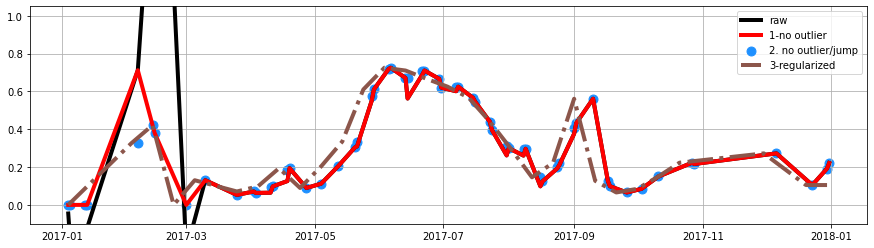

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4), sharex=False, sharey='col', # sharex=True, sharey=True,
                       gridspec_kw={'hspace': 0.35, 'wspace': .05});
ax.grid(True)


ax.plot(a_raw_field['human_system_start_time'], 
        a_raw_field[VI_idx], 
        linewidth=4, \
        label="raw",
        color=color_dict['raw'], 
        linestyle=style_dict["raw"]);

ax.plot(no_Outlier_TS['human_system_start_time'], 
        no_Outlier_TS[VI_idx], 
        linewidth=4, label="1-no outlier",\
        color=color_dict["outlier"], 
        linestyle=style_dict["outlier"]);

ax.scatter(no_Outlier_no_jump['human_system_start_time'], 
           no_Outlier_no_jump[VI_idx], 
           s=80, c="dodgerblue", label="2. no outlier/jump")


ax.plot(regularized_TS['human_system_start_time'], 
        regularized_TS[VI_idx], 
        linewidth=4, label="3-regularized", \
        color=color_dict['regular'],
        linestyle=style_dict['regular']);

ax.legend(loc="upper right");
ax.set_ylim(-0.1, 1.05)

# 4. SG

In [133]:
import scipy
import scipy.signal

In [134]:
SG = scipy.signal.savgol_filter(regularized_TS[VI_idx].values, window_length=7, polyorder=3)

(-0.1, 1.05)

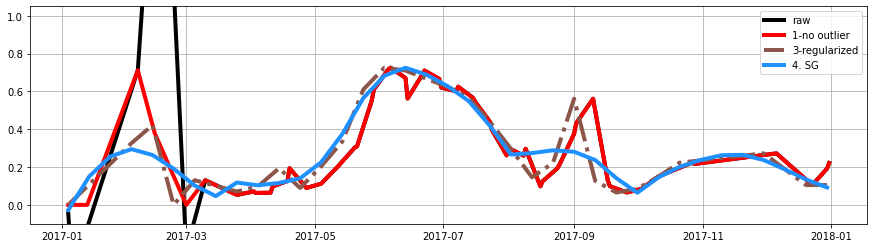

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4), sharex=False, sharey='col', # sharex=True, sharey=True,
                       gridspec_kw={'hspace': 0.35, 'wspace': .05});
ax.grid(True)


ax.plot(a_raw_field['human_system_start_time'], 
        a_raw_field[VI_idx], 
        linewidth=4, \
        label="raw",
        color=color_dict['raw'], 
        linestyle=style_dict["raw"]);

ax.plot(no_Outlier_TS['human_system_start_time'], 
        no_Outlier_TS[VI_idx], 
        linewidth=4, label="1-no outlier",\
        color=color_dict["outlier"], 
        linestyle=style_dict["outlier"]);

# ax.scatter(no_Outlier_no_jump['human_system_start_time'], 
#            no_Outlier_no_jump[VI_idx], 
#            s=80, c="dodgerblue", label="2. no outlier/jump")


ax.plot(regularized_TS['human_system_start_time'], 
        regularized_TS[VI_idx], 
        linewidth=4, label="3-regularized", \
        color=color_dict['regular'],
        linestyle=style_dict['regular']);

ax.plot(regularized_TS['human_system_start_time'], 
        SG, 
        linewidth=4, label="4. SG", \
        color="dodgerblue",
        linestyle=style_dict['SG']);

ax.legend(loc="upper right");
ax.set_ylim(-0.1, 1.05)

In [145]:
SG2 = scipy.signal.savgol_filter(SG, window_length=7, polyorder=3)

(-0.1, 1.05)

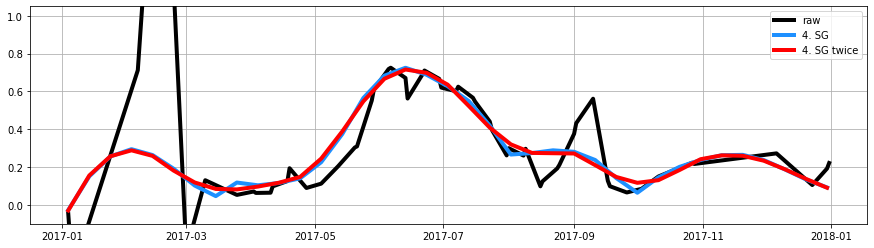

In [147]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4), sharex=False, sharey='col', # sharex=True, sharey=True,
                       gridspec_kw={'hspace': 0.35, 'wspace': .05});
ax.grid(True)


ax.plot(a_raw_field['human_system_start_time'], 
        a_raw_field[VI_idx], 
        linewidth=4, \
        label="raw",
        color=color_dict['raw'], 
        linestyle=style_dict["raw"]);

# ax.plot(no_Outlier_TS['human_system_start_time'], 
#         no_Outlier_TS[VI_idx], 
#         linewidth=4, label="1-no outlier",\
#         color=color_dict["outlier"], 
#         linestyle=style_dict["outlier"]);

# ax.scatter(no_Outlier_no_jump['human_system_start_time'], 
#            no_Outlier_no_jump[VI_idx], 
#            s=80, c="dodgerblue", label="2. no outlier/jump")


# ax.plot(regularized_TS['human_system_start_time'], 
#         regularized_TS[VI_idx], 
#         linewidth=4, label="3-regularized", \
#         color=color_dict['regular'],
#         linestyle=style_dict['regular']);

ax.plot(regularized_TS['human_system_start_time'], 
        SG, 
        linewidth=4, label="4. SG", \
        color="dodgerblue",
        linestyle=style_dict['SG']);

ax.plot(regularized_TS['human_system_start_time'], 
        SG2, 
        linewidth=4, label="4. SG twice", \
        color="red",
        linestyle=style_dict['SG']);

ax.legend(loc="upper right");
ax.set_ylim(-0.1, 1.05)